# このノートでやった（できる）こと
### Logistic regressionを用いて、目的変数の確率を算出し、算出した値を元に様々な掛け方をした場合の回収率を計算

#### 計算に用いた特徴量
- 各レーサーのクラス
- 各レーサーの各枠における平均スタートタイム
- 各レーサーの連帯率
- 展示タイム
- 各モーターの2連率
- 各モーターの3連率

#### 目的変数
- 1枠: 1着になる (1) or ならない (0)
- 2-6枠: 3着以内にはいる (1) or 入らない (0)


### 結果
#### Logistic Regression結果
- 分類器としてそのまま使うことはできない（正解率6割程度）が、
- うまく予想することができている（LRを用いて求めた確率が高いところでは実際1が成立し、低いところでは0が成立する率が高い）

#### bet結果


In [65]:
# 必要なモジュールのインポート

from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import termcolor

import sys
import os

current_dir = os.getcwd()
sys.path.append(os.path.join(current_dir, '../conf/'))
sys.path.append(os.path.join(current_dir, '../crawl/'))
sys.path.append(os.path.join(current_dir, '../data_preparing/'))
sys.path.append(os.path.join(current_dir, 'analyzer_conf/'))

# my module
import loader
import boatrace_crawler_conf
import analyzer_conf

In [51]:
# 過去のレース結果をdfとして取得
the_merged_df = loader.make_merged_df()
# dfをソート
the_merged_df = the_merged_df.sort_values(["date", "venue", "raceNumber"])
# print(the_merged_df["exhibitionTime_1"])

In [52]:
# logistic regressionを利用した学習

def make_df_for_analyze(merged_df, fv_list, column_list_label, odds_list):
    """
    parameters
        fv_list: dfのうち、特徴量として用いるカラム名のリスト
        column_list_label: dfのうち、labelとして用いるカラム名のリスト
    """
    
    # ラベルの数を変数名にしておく。labelと特徴量を分けるときに使う
    num_labels = len(column_list_label)

    # 解析用dfを作成
    fv_label_odds_df = the_merged_df[fv_list + column_list_label + odds_list]
    
    # nanを含む行を削除
    fv_label_odds_df = fv_label_odds_df.dropna()
    
    # oddsはないバージョンのdf
    fv_label_df = fv_label_odds_df[fv_list + column_list_label ]
    
    # クラスカラムを，A1 =0, A2 = 1のように数字に変換する
    class_dict = {"A1": 0, "A2":1, "B1": 2, "B2": 3}
    for key, value in class_dict.items():
        fv_label_df.replace(key, value, inplace = True)

    # なぜかdtypeがstrになっちゃうのでintに戻す
    fv_labe_df = fv_label_df.astype(float)

    # ラベルをbooleanに変換
    fv_label_df = analyzer_conf.make_label_boolean_ver1(
        fv_label_df, column_list_label)
    print("解析用dfの行数は.{0}".format(len(fv_label_df)))
    
    """
    # 特徴量を標準化
    fv_label_df = analyzer_conf.standerdize_feature_values(
        fv_label_df, column_list_label)
    """        
    return fv_label_df, fv_label_odds_df


def separate_train_test_dataset(for_analysis_df, train_data_ratio):
       
    # 解析用df（特徴量+label）を、学習用データとテストデータのarrayに分ける
    train_size = int(len(for_analysis_df) * train_data_ratio)
    train_data = for_analysis_df[:train_size].values
    test_data = for_analysis_df[train_size:].values
    
    return train_data, test_data, train_size

    
def learn_logistic_regression(train_data, column_list_label):
    
    """
    1枠が1着になるかどうか？2枠以降に関しては3着以内に入るかどうか？を scikit-lernのlogistic regressionを用いて学習する。
    複数のラベルをリストとして入力することが可能で、戻り値はそれぞれのlabelに対して学習を行なった結果のモデルを各要素にもつリスト
    
    return
        clf_list: 各ラベルについて学習したモデルのlist
    
    TODO
        ラベルの作成方法などもinput parameterとして指定できた方がいい。
        むしろregressionの方法もinputにして超汎用的な関数を外側に作るか？
    
    """
    # ラベルとしてもちいる部分の数。labelと特徴量を分ける際に使用、
    num_labels = len(column_list_label)
    
    # 特徴量部分のarray
    train_x = train_data[:, :-num_labels]

    # ロジスティック回帰を行なった結果得られるオブジェクトをリストに格納
    clf_list  = []

    for i, column_label in enumerate(column_list_label):
        # ラベルを指定
        train_t = train_data[:, - num_labels + i]

        # ロジスティック回帰
        clf = LogisticRegression()
        clf.fit(train_x, train_t)

        clf_list.append(clf)
    
    return clf_list, num_labels


# ----------input-------------
# 解析に使う特徴量カラム
fv_list = []
for i in range(1, 7):
    # 各枠のレーサーのクラス
    fv_list.append("class_{0}".format(i))
    # 各枠の平均ST
    fv_list.append("aveST_frame{0}".format(i))
    # 連帯率
    fv_list.append("placeRate_frame{0}".format(i))
    # 展示タイム
    fv_list.append("exhibitionTime_{0}".format(i))
    
    # 各モーターの2連率, 3連率
    fv_list.append("motor_place2Ratio_{0}".format(i))
    fv_list.append("motor_place3Ratio_{0}".format(i))

# 解析に使うラベルカラム: 1枠が1着になるか, 2枠以降は3着以降に入るかどうか？を予測
column_list_label = ["rank_{0}".format(i) for i in range(1,7)]

# 回収率計算に使用するオッズラベルのリスト
odds_list =  ["win", "winOdds", 
             "place_1", "placeOdds_1",
             "place_2", "placeOdds_2",
             "exacta", "exactaOdds",
             "quinella", "quinellaOdds",
             "wide_1", "wideOdds_1", 
             "wide_2", "wideOdds_2",
             "wide_3", "wideOdds_3",
             "trifecta", "trifectaOdds",
             "trio", "trioOdds"]

# データのうち、教師データとして使う割合（残りをテストデータとして用いる）
train_data_ratio = 0.7

# --------------------------------

# main

fv_label_df, fv_label_odds_df = make_df_for_analyze(the_merged_df, fv_list, column_list_label, odds_list)
train_data, test_data, train_size = separate_train_test_dataset(fv_label_df, train_data_ratio)
clf_list, num_labels = learn_logistic_regression(train_data, column_list_label)

/usr/local/lib/python3.6/site-packages/pandas/core/frame.py:3798: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)
/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


解析用dfの行数は.4752


/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

1号艇についてtrainデータを使った正解率は0.6641611545399879,
           testデータを使った正解率は0.6465638148667602
切片は[0.212161]
class_1 -0.5428620995284599 

aveST_frame1 -0.027358660787296398 

placeRate_frame1 0.0017297116499843243 

exhibitionTime_1 -2.991270866872947 

motor_place2Ratio_1 0.005974647727992198 

motor_place3Ratio_1 0.005006779655349703 

class_2 0.08733621153164159 

aveST_frame2 -0.017674572810500243 

placeRate_frame2 -0.00046013815501465337 

exhibitionTime_2 0.6267778831836898 

motor_place2Ratio_2 0.014475058270188032 

motor_place3Ratio_2 -0.013698036609506829 

class_3 0.008300153532748643 

aveST_frame3 -0.002780078498969088 

placeRate_frame3 -0.0005560877994989364 

exhibitionTime_3 1.282825501926819 

motor_place2Ratio_3 -0.002676402982079138 

motor_place3Ratio_3 -0.003884731256830573 

class_4 0.07880288908012738 

aveST_frame4 0.010020114072491735 

placeRate_frame4 -0.00029302353962840967 

exhibitionTime_4 1.0333326176948439 

motor_place2Ratio_4 -0.017065022446714602 

motor

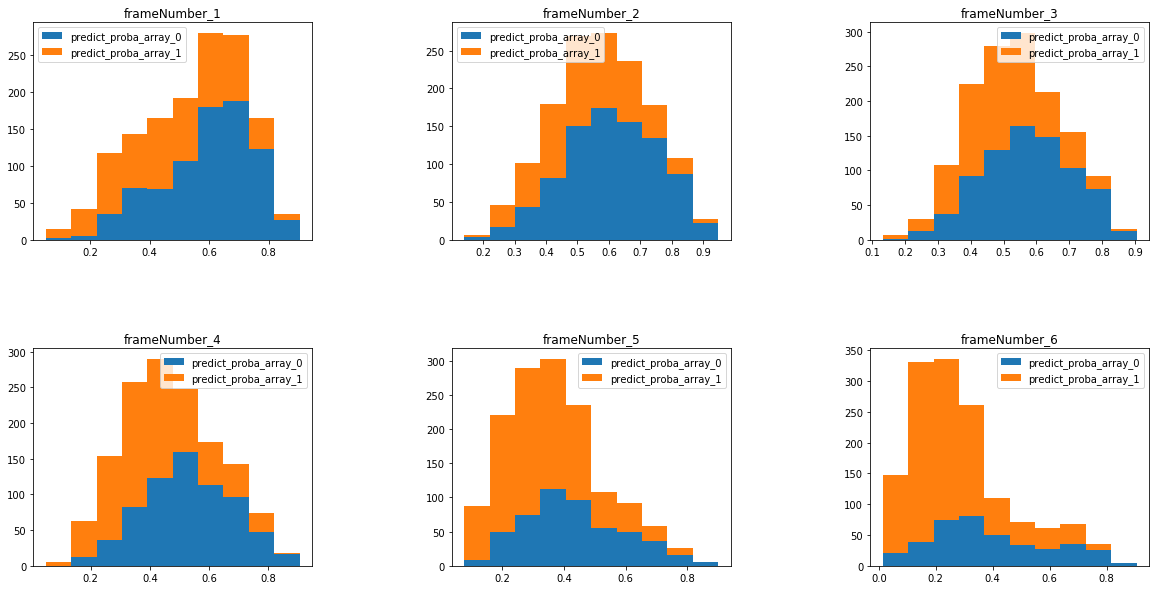

In [53]:
"""
上のセルで学習したclfを用いて色々と解析する。
今このセルで行なっている解析は
1. 各labelについて正解率を計算
2. 最適化された結果の切片および各係数を表示
3. テストデータについて、学習結果を適用した際に、ラベルが1になる確率を、実際のラベル　1 or　0で色分けしてヒストグラムを作成

"""
# 描画用の枠を用意

plt.figure(figsize=(20, 10))
plt.subplots_adjust(wspace=0.5,hspace=0.5)

# 回収率計算用に、[predict_proba_array, test_t]を各要素にもつリストを作成
predict_proba_array_list = []

# 正解率の計算などのため、train data, test dataそれぞれについて、特徴量部分のarrayとlabel部分のarrayを作成
train_x = train_data[:, :-num_labels]
test_x = test_data[:, :-num_labels]

for i, clf in enumerate(clf_list):
    train_t = train_data[:, - num_labels + i]
    test_t = test_data[:, - num_labels + i]
    
    # 正解率を計算
    train_score = clf.score(train_x, train_t)
    test_score = clf.score(test_x, test_t)
    print("{2}号艇についてtrainデータを使った正解率は{0},\n \
          testデータを使った正解率は{1}".format(train_score, test_score, i + 1))

    # 最適化された結果の切片と重みを取得
    intercept =clf.intercept_
    coef = clf.coef_
    print("切片は{0}".format(intercept))
    for j in range (coef.shape[1]):
        print(fv_list[j], coef[0, j], "\n")

    # テストデータについて、学習結果を適用した際に、ラベルが1になる確率を、実際のラベル　1 or　0で色分けしてヒストグラムを作成
    predict_proba_array = clf.predict_proba(test_x)
    
    # listに格納しておく
    predict_proba_array_list.append(predict_proba_array[:, 1])

    # 結果が1 (1枠が一着 , 2枠以降が3着以内) だったものの推定確率
    predict_proba_array_1 = predict_proba_array[:, 1][test_t==1]

    # 結果が0 (1枠以外が一着, 1枠以外の場合は4着以降) だったものの推定確率
    predict_proba_array_0 = predict_proba_array[:, 1][test_t==0]

    # 積み上げヒストグラムを作成
    title = "frameNumber_{0}".format(i + 1)
    labels = {'predict_proba_array_1', 'predict_proba_array_0'}
    plt.subplot(2, 3, i+1)
    plt.hist([predict_proba_array_1, predict_proba_array_0], histtype="barstacked", label=labels)
    plt.title(title)
    plt.legend()
plt.show()


# 考察
- 正解率はいずれのラベルに対しても6割から7割程度にとどまるが、test dataとtraining dataで同程度の正解率をだす。
確率ごとにプロットをしてみると、
- predict_probaが小さい時は実際に0ラベル、predict_probaが大きい時は実際に1ラベルであることがかなり多くなっている。
- 正解率を下げているのは実際に判断が難しいところ（0.3 < predict_proba < 0.7くらいの場所） であり、predict_probaが高いところ、低いところを抽出して用いることで十分に予測器として使用可能
- 1着以外が1位になる，荒れるレースの予測や、1着を1枠に固定し、2, 3を高いprobabilityを示すものでbox買するといったオプションが考えられる。

そこで、以下のセルにおいては掛け方を色々してみた時の回収率計算を行う。

In [54]:
# 計算用dfを作成
# 6列目までが上の解析によって求めた確率(1号艇が1位になる率, 2-6号艇が3位以内に入る確率)
# 7列目以降にオッズ関係の値を格納

for_calc_refund_rate_df = pd.DataFrame(np.vstack(predict_proba_array_list).T, columns=["PredProb_{0}".format(i) for i in range(1, 7)])
for odds_column_name in odds_list:
    # TODO intで入れられるものはintで。無理なものはとりあえずobjectのままで格納
    for_calc_refund_rate_df[odds_column_name] = fv_label_odds_df[odds_column_name][train_size:].values

print(for_calc_refund_rate_df)

      PredProb_1  PredProb_2  PredProb_3  PredProb_4  PredProb_5  PredProb_6  \
0       0.563546    0.585990    0.394611    0.518853    0.397592    0.272135   
1       0.577293    0.524996    0.635683    0.382392    0.398463    0.235845   
2       0.659289    0.575084    0.574231    0.336943    0.396684    0.237950   
3       0.636852    0.525055    0.533909    0.435773    0.342948    0.256457   
4       0.603947    0.538210    0.625922    0.389447    0.409417    0.234080   
5       0.639869    0.617169    0.546139    0.456448    0.299462    0.197315   
6       0.561987    0.524433    0.557622    0.448348    0.405064    0.282097   
7       0.582336    0.504768    0.581361    0.475391    0.421787    0.275983   
8       0.625156    0.517569    0.550186    0.439451    0.339184    0.289631   
9       0.618282    0.459226    0.703342    0.322638    0.324286    0.351812   
10      0.501710    0.482059    0.648240    0.497621    0.391382    0.183838   
11      0.735529    0.646425    0.469687

In [55]:
# 確率x_1以上のときのみ、1に単勝賭けした時の回収率
x_1_list = [0.6, 0.7, 0.8]
for x_1 in x_1_list:
    bet = sum(for_calc_refund_rate_df["PredProb_1"] > x_1)

    return_boolean = (for_calc_refund_rate_df["PredProb_1"] > x_1) & (for_calc_refund_rate_df["win"] == "1")
    return_ = sum(for_calc_refund_rate_df["winOdds"][return_boolean])

    print("確率{0}以上で1に単勝betした場合、的中率は{1}, 回収率は{2}".format(x_1, sum(return_boolean) / bet, return_ / (bet * 100)))

確率0.6以上で1に単勝betした場合、的中率は0.6949152542372882, 回収率は0.9277349768875193
確率0.7以上で1に単勝betした場合、的中率は0.7411003236245954, 回収率は0.9194174757281554
確率0.8以上で1に単勝betした場合、的中率は0.8360655737704918, 回収率は1.0081967213114753


In [56]:
# 1号艇の勝率x_1以上の時、他の艇で3位以内率がx_2超えがあった場合に、1-XY..の形で2連単bet

x_1_list = [0.7, 0.75, 0.8]
x_2_list = [0.5, 0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        income = 0
        bet = 0

        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                for j in range(2, 7):
                    if row["PredProb_{0}".format(j)] > x_2:
                        bet_num = "1-{0}".format(j)
                        bet = bet + 100
                        if row["exacta"] == bet_num:
                            income = income + row["exactaOdds"]
        print("p1が{0}以上かつ、p2-6が{1}以上で2連単betすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet))

p1が0.7以上かつ、p2-6が0.5以上で2連単betすると収益は-10660, 回収率は0.7961759082217973
p1が0.7以上かつ、p2-6が0.6以上で2連単betすると収益は-5630, 回収率は0.7774703557312252
p1が0.7以上かつ、p2-6が0.7以上で2連単betすると収益は-1860, 回収率は0.7837209302325582
p1が0.7以上かつ、p2-6が0.8以上で2連単betすると収益は260, 回収率は1.2
p1が0.75以上かつ、p2-6が0.5以上で2連単betすると収益は-3590, 回収率は0.8558232931726908
p1が0.75以上かつ、p2-6が0.6以上で2連単betすると収益は-790, 回収率は0.9233009708737864
p1が0.75以上かつ、p2-6が0.7以上で2連単betすると収益は-630, 回収率は0.7827586206896552
p1が0.75以上かつ、p2-6が0.8以上で2連単betすると収益は80, 回収率は1.2666666666666666
p1が0.8以上かつ、p2-6が0.5以上で2連単betすると収益は-750, 回収率は0.9166666666666666
p1が0.8以上かつ、p2-6が0.6以上で2連単betすると収益は-690, 回収率は0.7909090909090909
p1が0.8以上かつ、p2-6が0.7以上で2連単betすると収益は-140, 回収率は0.86
p1が0.8以上かつ、p2-6が0.8以上で2連単betすると収益は-100, 回収率は0.0


In [57]:
# 1号艇の勝率x_1以上の時、他の艇で3位以内率x_2超えがあった場合に、1-X-9と1-9-Xの形で3連単bet
x_1_list = [0.6, 0.7, 0.8]
x_2_list = [0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        
        income = 0
        bet = 0
        
        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                for j in range(2, 7):
                    if row["PredProb_{0}".format(j)] > x_2:
                        for k in range(2, 7):
                            if k is not j:
                                bet = bet + 200
                                bet_num_1 = "1-{0}-{1}".format(j, k)
                                bet_num_2 = "1-{0}-{1}".format(k, j)
                                # print(bet_num_1, bet_num_2, row["trifecta"], row["trifectaOdds"])
                                if row["trifecta"] == bet_num_1 or row["trifecta"] == bet_num_2:
                                    income = income + row["trifectaOdds"]
        print("p1が{0}以上かつ、p2-6が{1}以上で3連単betすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet))

p1が0.6以上かつ、p2-6が0.6以上で3連単betすると収益は-94570, 回収率は0.8058908045977011
p1が0.6以上かつ、p2-6が0.7以上で3連単betすると収益は-29940, 回収率は0.831418918918919
p1が0.6以上かつ、p2-6が0.8以上で3連単betすると収益は-4620, 回収率は0.86875
p1が0.7以上かつ、p2-6が0.6以上で3連単betすると収益は-31360, 回収率は0.8450592885375494
p1が0.7以上かつ、p2-6が0.7以上で3連単betすると収益は-14950, 回収率は0.782703488372093
p1が0.7以上かつ、p2-6が0.8以上で3連単betすると収益は-1640, 回収率は0.8423076923076923
p1が0.8以上かつ、p2-6が0.6以上で3連単betすると収益は820, 回収率は1.031060606060606
p1が0.8以上かつ、p2-6が0.7以上で3連単betすると収益は-2940, 回収率は0.6325
p1が0.8以上かつ、p2-6が0.8以上で3連単betすると収益は-800, 回収率は0.0


In [58]:
# 上と同じノリで2着固定。すなわち、
# 1号艇の勝率x_1以上の時、他の艇で3位以内率x_2超えがあった場合に、1-X-9の形で3連単bet
x_1_list = [0.5, 0.6, 0.7, 0.8]
x_2_list = [0.4, 0.5, 0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        
        income = 0
        bet = 0
        
        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                for j in range(2, 7):
                    if row["PredProb_{0}".format(j)] > x_2:
                        for k in range(2, 7):
                            if k is not j:
                                bet = bet + 100
                                bet_num = "1-{0}-{1}".format(j, k)
                                if row["trifecta"] == bet_num:
                                    income = income + row["trifectaOdds"]
        print("p1が{0}以上かつ、p2-6が{1}以上で3連単betすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet))

p1が0.5以上かつ、p2-6が0.4以上で3連単betすると収益は-245170, 回収率は0.7602014866979656
p1が0.5以上かつ、p2-6が0.5以上で3連単betすると収益は-142920, 回収率は0.7839782345828296
p1が0.5以上かつ、p2-6が0.6以上で3連単betすると収益は-71350, 回収率は0.8000280269058296
p1が0.5以上かつ、p2-6が0.7以上で3連単betすると収益は-24450, 回収率は0.8233381502890174
p1が0.5以上かつ、p2-6が0.8以上で3連単betすると収益は5270, 回収率は1.1711038961038962
p1が0.6以上かつ、p2-6が0.4以上で3連単betすると収益は-161800, 回収率は0.775027808676307
p1が0.6以上かつ、p2-6が0.5以上で3連単betすると収益は-98890, 回収率は0.7853949652777777
p1が0.6以上かつ、p2-6が0.6以上で3連単betすると収益は-46940, 回収率は0.8073070607553366
p1が0.6以上かつ、p2-6が0.7以上で3連単betすると収益は-12560, 回収率は0.8585585585585586
p1が0.6以上かつ、p2-6が0.8以上で3連単betすると収益は2950, 回収率は1.1676136363636365
p1が0.7以上かつ、p2-6が0.4以上で3連単betすると収益は-76490, 回収率は0.7698856799037305
p1が0.7以上かつ、p2-6が0.5以上で3連単betすると収益は-44520, 回収率は0.7871892925430211
p1が0.7以上かつ、p2-6が0.6以上で3連単betすると収益は-16060, 回収率は0.841304347826087
p1が0.7以上かつ、p2-6が0.7以上で3連単betすると収益は-6490, 回収率は0.8113372093023256
p1が0.7以上かつ、p2-6が0.8以上で3連単betすると収益は3560, 回収率は1.6846153846153846
p1が0.8以上かつ、p2-6が0.4以上で3連単betすると

In [59]:
# 1号艇の勝率x_1以上の時、他の艇で3位以内率x_2以下が2艇以上あった場合に、1頭で、2割以下艇を外した残りを2, 3着boxにして買う
x_1_list = [0.6, 0.7, 0.8]
x_2_list = [0.4, 0.3, 0.2]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        
        income = 0
        bet = 0
        
        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                outers = (row[["PredProb_{0}".format(n) for n in range(2, 7)]] < x_2)
                num_outers = sum(outers)
                if (num_outers > 1):
                    for j in range(2, 7):
                        if row["PredProb_{0}".format(j)] > x_2:
                            for k in range(2, 7):
                                if k is not j and row["PredProb_{0}".format(k)] > x_2:
                                    bet = bet + 100
                                    bet_num = "1-{0}-{1}".format(j, k)
                                    if row["trifecta"] == bet_num:
                                        income = income + row["trifectaOdds"]
        print("p1が{0}以上かつ、p2-6が{1}以上で3連単betすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet))

p1が0.6以上かつ、p2-6が0.4以上で3連単betすると収益は-21030, 回収率は0.9205815709969789
p1が0.6以上かつ、p2-6が0.3以上で3連単betすると収益は-35860, 回収率は0.7516620498614959
p1が0.6以上かつ、p2-6が0.2以上で3連単betすると収益は-3010, 回収率は0.8432291666666667
p1が0.7以上かつ、p2-6が0.4以上で3連単betすると収益は-14840, 回収率は0.8803225806451613
p1が0.7以上かつ、p2-6が0.3以上で3連単betすると収益は-20850, 回収率は0.6995677233429395
p1が0.7以上かつ、p2-6が0.2以上で3連単betすると収益は-6390, 回収率は0.334375
p1が0.8以上かつ、p2-6が0.4以上で3連単betすると収益は4330, 回収率は1.1819327731092437
p1が0.8以上かつ、p2-6が0.3以上で3連単betすると収益は1510, 回収率は1.104861111111111
p1が0.8以上かつ、p2-6が0.2以上で3連単betすると収益は-1800, 回収率は0.0


In [62]:
# 1号艇の勝率x_1以上の時、他の艇で3位以内率x_2以上が2艇以上あった場合に、1頭で、x_2以上艇を2, 3着boxにして買う
x_1_list = [0.5, 0.6, 0.7, 0.75, 0.8]
x_2_list = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        
        income = 0
        bet = 0
        
        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                for j in range(2, 7):
                    if row["PredProb_{0}".format(j)] > x_2:
                        for k in range(2, 7):
                            if k is not j and row["PredProb_{0}".format(k)] > x_2:
                                bet = bet + 100
                                bet_num = "1-{0}-{1}".format(j, k)
                                if row["trifecta"] == bet_num:
                                    income = income + row["trifectaOdds"]
                                # print(bet_num, row["trifecta"], row["trifectaOdds"], bet, income)
        try:
            print("p1が{0}以上かつ、p2-6が{1}以上で3連単betすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet))
        except ZeroDivisionError:
            print("投票候補なし")

p1が0.5以上かつ、p2-6が0.3以上で3連単betすると収益は-192990, 回収率は0.7998444306160548
p1が0.5以上かつ、p2-6が0.4以上で3連単betすると収益は-75110, 回収率は0.8515025701858442
p1が0.5以上かつ、p2-6が0.5以上で3連単betすると収益は-23200, 回収率は0.8695163104611924
p1が0.5以上かつ、p2-6が0.6以上で3連単betすると収益は-11480, 回収率は0.7266666666666667
p1が0.5以上かつ、p2-6が0.7以上で3連単betすると収益は-1860, 回収率は0.5571428571428572
p1が0.5以上かつ、p2-6が0.8以上で3連単betすると収益は330, 回収率は1.825
p1が0.6以上かつ、p2-6が0.3以上で3連単betすると収益は-159100, 回収率は0.7640865954922894
p1が0.6以上かつ、p2-6が0.4以上で3連単betすると収益は-37880, 回収率は0.890139211136891
p1が0.6以上かつ、p2-6が0.5以上で3連単betすると収益は-23260, 回収率は0.8032148900169205
p1が0.6以上かつ、p2-6が0.6以上で3連単betすると収益は-7660, 回収率は0.7264285714285714
p1が0.6以上かつ、p2-6が0.7以上で3連単betすると収益は-190, 回収率は0.8944444444444445
p1が0.6以上かつ、p2-6が0.8以上で3連単betすると収益は-200, 回収率は0.0
p1が0.7以上かつ、p2-6が0.3以上で3連単betすると収益は-104410, 回収率は0.6702147820593809
p1が0.7以上かつ、p2-6が0.4以上で3連単betすると収益は-18280, 回収率は0.8803664921465969
p1が0.7以上かつ、p2-6が0.5以上で3連単betすると収益は-8220, 回収率は0.8349397590361446
p1が0.7以上かつ、p2-6が0.6以上で3連単betすると収益は-1750, 回収率は0.81770833333333

In [71]:
# 1号艇の勝率x_1以上の時、他の艇で3位以内率x_2以上が1艇, X_3以上が1艇以上あった場合に、1頭で、x_2以上艇を2, 3着boxにして買う
# ただし、2-6号艇のうち二つ以上の艇がx_２を超えていた場合、それらに対しては2倍のbet額になるアルゴリズムになっている
x_1_list = [0.4, 0.5, 0.6, 0.7, 0.8]
x_2_list = [0.4, 0.5, 0.6, 0.7, 0.8]
x_3_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        for x_3 in x_3_list:
            if x_3 <= x_2:

                income = 0
                bet = 0

                for index, row in for_calc_refund_rate_df.iterrows():
                    if (row["PredProb_1"] > x_1):
                        for j in range(2, 7):
                            if row["PredProb_{0}".format(j)] > x_2:
                                for k in range(2, 7):
                                    if k is not j and row["PredProb_{0}".format(k)] > x_3:
                                        bet = bet + 200
                                        bet_num_1 = "1-{0}-{1}".format(j, k)
                                        bet_num_2 = "1-{0}-{1}".format(k, j)

                                        if row["trifecta"] == bet_num_1 or row["trifecta"] == bet_num_2:
                                            income = income + row["trifectaOdds"]
                                        # print(bet_num, row["trifecta"], row["trifectaOdds"], bet, income)
                try:
                    text = "p1が{0}以上かつ、p2が{1}以上かつp3が{2}で3連単betすると収益は{3}, 回収率は{4}".format(x_1, x_2, x_3, income-bet, income/bet)
                    if (income / bet) < 1:
                        text = termcolor.colored(text, "red")
                    print(text)
                except ZeroDivisionError:
                    print("p1={0}, p2={1}, p3={2}の時、投票候補なし".format(x_1, x_2, x_3))

p1が0.4以上かつ、p2が0.4以上かつp3が0で3連単betすると収益は-602730, 回収率は0.7605173235855054
p1が0.4以上かつ、p2が0.4以上かつp3が0.1で3連単betすると収益は-559020, 回収率は0.7713058419243987
p1が0.4以上かつ、p2が0.4以上かつp3が0.2で3連単betすると収益は-464440, 回収率は0.7869541284403669
p1が0.4以上かつ、p2が0.4以上かつp3が0.3で3連単betすると収益は-378280, 回収率は0.784332953249715
p1が0.4以上かつ、p2が0.4以上かつp3が0.4で3連単betすると収益は-221880, 回収率は0.8252362948960302
p1が0.4以上かつ、p2が0.5以上かつp3が0で3連単betすると収益は-317540, 回収率は0.8097195589645254
p1が0.4以上かつ、p2が0.5以上かつp3が0.1で3連単betすると収益は-291430, 回収率は0.8194361833952912
p1が0.4以上かつ、p2が0.5以上かつp3が0.2で3連単betすると収益は-221560, 回収率は0.8443007730147576
p1が0.4以上かつ、p2が0.5以上かつp3が0.3で3連単betすると収益は-175920, 回収率は0.8439595529536987
p1が0.4以上かつ、p2が0.5以上かつp3が0.4で3連単betすると収益は-100320, 回収率は0.8737477976340297
p1が0.4以上かつ、p2が0.5以上かつp3が0.5で3連単betすると収益は-49320, 回収率は0.8969924812030076
p1が0.4以上かつ、p2が0.6以上かつp3が0で3連単betすると収益は-229680, 回収率は0.7514285714285714
p1が0.4以上かつ、p2が0.6以上かつp3が0.1で3連単betすると収益は-221170, 回収率は0.7505976544880469
p1が0.4以上かつ、p2が0.6以上かつp3が0.2で3連単betすると収益は-154120, 回収率は0.7996359854394176


p1が0.7以上かつ、p2が0.4以上かつp3が0.2で3連単betすると収益は-139460, 回収率は0.7551615168539326
p1が0.7以上かつ、p2が0.4以上かつp3が0.3で3連単betすると収益は-105220, 回収率は0.764397671294223
p1が0.7以上かつ、p2が0.4以上かつp3が0.4で3連単betすると収益は-36560, 回収率は0.8803664921465969
p1が0.7以上かつ、p2が0.5以上かつp3が0で3連単betすると収益は-58340, 回収率は0.8605640535372849
p1が0.7以上かつ、p2が0.5以上かつp3が0.1で3連単betすると収益は-57350, 回収率は0.8572672971627675
p1が0.7以上かつ、p2が0.5以上かつp3が0.2で3連単betすると収益は-72920, 回収率は0.7927231381466743
p1が0.7以上かつ、p2が0.5以上かつp3が0.3で3連単betすると収益は-61890, 回収率は0.7721281296023564
p1が0.7以上かつ、p2が0.5以上かつp3が0.4で3連単betすると収益は-22190, 回収率は0.8758948545861297
p1が0.7以上かつ、p2が0.5以上かつp3が0.5で3連単betすると収益は-16440, 回収率は0.8349397590361446
p1が0.7以上かつ、p2が0.6以上かつp3が0で3連単betすると収益は-31360, 回収率は0.8450592885375494
p1が0.7以上かつ、p2が0.6以上かつp3が0.1で3連単betすると収益は-35770, 回収率は0.812918410041841
p1が0.7以上かつ、p2が0.6以上かつp3が0.2で3連単betすると収益は-31010, 回収率は0.812060606060606
p1が0.7以上かつ、p2が0.6以上かつp3が0.3で3連単betすると収益は-32390, 回収率は0.7404647435897436
p1が0.7以上かつ、p2が0.6以上かつp3が0.4で3連単betすると収益は-15660, 回収率は0.8037593984962406
p1が0.7以上かつ、

2019年1月の一月に絞ってまわした場合、
下記のような特徴があり、相当うまく行っていることがわかる。正直このまま自動betアルゴリズムにできそう。
- かなりいろんな値で回収率がちゃんとプラスになる
- p1, p2の特定の値でマイナスになったりはしない
- p値を厳しく取るほど回収率は上がる傾向がある。

かと思ったけどそうでもないかな。。。

In [67]:
# 1号艇の勝率x_1以上の時、他の艇で3位以内率x_2以上が1艇, X_3以上が1艇以上あった場合
# 1頭で、x_2以上艇を2着候補に, x_３以上の艇を3着候補にしてbet
x_1_list = [0.4, 0.5, 0.6, 0.7, 0.8]
x_2_list = [0.4, 0.5, 0.6, 0.7, 0.8]
x_3_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        for x_3 in x_3_list:

            income = 0
            bet = 0

            for index, row in for_calc_refund_rate_df.iterrows():
                if (row["PredProb_1"] > x_1):
                    for j in range(2, 7):
                        if row["PredProb_{0}".format(j)] > x_2:
                            for k in range(2, 7):
                                if k is not j and row["PredProb_{0}".format(k)] > x_3:
                                    bet = bet + 100
                                    bet_num = "1-{0}-{1}".format(j, k)
                                    
                                    if row["trifecta"] == bet_num:
                                        income = income + row["trifectaOdds"]
                                    # print(bet_num, row["trifecta"], row["trifectaOdds"], bet, income)
            try:
                text = "p1が{0}以上かつ、p2が{1}以上かつp3が{2}で3連単betすると収益は{3}, 回収率は{4}".format(x_1, x_2, x_3, income-bet, income/bet)
                if (income/bet) < 1:
                    text = termcolor.colored(text, 'red')
                print(text)
            except ZeroDivisionError:
                print("p1={0}, p2={1}, p3={2}の時、投票候補なし".format(x_1, x_2, x_3))

p1が0.4以上かつ、p2が0.4以上かつp3が0で3連単betすると収益は-323370, 回収率は0.7430308328035601
p1が0.4以上かつ、p2が0.4以上かつp3が0.1で3連単betすると収益は-315860, 回収率は0.741564392079856
p1が0.4以上かつ、p2が0.4以上かつp3が0.2で3連単betすると収益は-284130, 回収率は0.7393302752293578
p1が0.4以上かつ、p2が0.4以上かつp3が0.3で3連単betすると収益は-212970, 回収率は0.7571607753705816
p1が0.4以上かつ、p2が0.4以上かつp3が0.4で3連単betすると収益は-110940, 回収率は0.8252362948960302
p1が0.4以上かつ、p2が0.4以上かつp3が0.5で3連単betすると収益は-39410, 回収率は0.9008054366977095
p1が0.4以上かつ、p2が0.4以上かつp3が0.6で3連単betすると収益は-38630, 回収率は0.813561776061776
p1が0.4以上かつ、p2が0.4以上かつp3が0.7で3連単betすると収益は-13120, 回収率は0.8307096774193549
p1が0.4以上かつ、p2が0.4以上かつp3が0.8で3連単betすると収益は120, 回収率は1.006857142857143
p1が0.4以上かつ、p2が0.5以上かつp3が0で3連単betすると収益は-207730, 回収率は0.751042665388303
p1が0.4以上かつ、p2が0.5以上かつp3が0.1で3連単betすると収益は-209020, 回収率は0.7409913258983891
p1が0.4以上かつ、p2が0.5以上かつp3が0.2で3連単betすると収益は-165300, 回収率は0.7676739283204498
p1が0.4以上かつ、p2が0.5以上かつp3が0.3で3連単betすると収益は-123540, 回収率は0.7808408728046834
p1が0.4以上かつ、p2が0.5以上かつp3が0.4で3連単betすると収益は-60910, 回収率は0.8466901585703499
p1が0.4以上

p1が0.6以上かつ、p2が0.6以上かつp3が0で3連単betすると収益は-46940, 回収率は0.8073070607553366
p1が0.6以上かつ、p2が0.6以上かつp3が0.1で3連単betすると収益は-56310, 回収率は0.7566551426101988
p1が0.6以上かつ、p2が0.6以上かつp3が0.2で3連単betすると収益は-49000, 回収率は0.7548774387193596
p1が0.6以上かつ、p2が0.6以上かつp3が0.3で3連単betすると収益は-40570, 回収率は0.7358723958333333
p1が0.6以上かつ、p2が0.6以上かつp3が0.4で3連単betすると収益は-20290, 回収率は0.800883218842002
p1が0.6以上かつ、p2が0.6以上かつp3が0.5で3連単betすると収益は-19330, 回収率は0.6678694158075601
p1が0.6以上かつ、p2が0.6以上かつp3が0.6で3連単betすると収益は-7660, 回収率は0.7264285714285714
p1が0.6以上かつ、p2が0.6以上かつp3が0.7で3連単betすると収益は820, 回収率は1.1012345679012345
p1が0.6以上かつ、p2が0.6以上かつp3が0.8で3連単betすると収益は-800, 回収率は0.38461538461538464
p1が0.6以上かつ、p2が0.7以上かつp3が0で3連単betすると収益は-12560, 回収率は0.8585585585585586
p1が0.6以上かつ、p2が0.7以上かつp3が0.1で3連単betすると収益は-12820, 回収率は0.8457280385078219
p1が0.6以上かつ、p2が0.7以上かつp3が0.2で3連単betすると収益は-14880, 回収率は0.788034188034188
p1が0.6以上かつ、p2が0.7以上かつp3が0.3で3連単betすると収益は-19360, 回収率は0.6284069097888676
p1が0.6以上かつ、p2が0.7以上かつp3が0.4で3連単betすると収益は-9690, 回収率は0.7166666666666667
p1が0.6以上かつ、p2が0.7以

2019年1月のデータに絞ってまわした場合、一つ上のセルの結果と同様、かなり安定して回収することを見込めそう。
ただ、こっちの方が実はばらけが出そう。例えばp1 = 0.7, p2 = 0.8の時。p3が0.1と0.6で回収率プラスに出るけど、これはでかいのを一発当てただけっぽい予感がする。

In [25]:
# 1号艇以外の艇で3位以内率x_2以上が2艇あった場合に、XY(Z)のワイド
x_2_list = [0.5, 0.6, 0.7, 0.8]

for x_2 in x_2_list:

    income = 0
    bet = 0

    for index, row in for_calc_refund_rate_df.iterrows():
        for j in range(2, 7):
            if row["PredProb_{0}".format(j)] > x_2:
                for k in range(j, 7):
                    if k is not j and row["PredProb_{0}".format(k)] > x_2:
                        bet = bet + 100
                        bet_num = "{0}-{1}".format(j, k)
                        if row["wide_1"] == bet_num:
                            income = income + row["wideOdds_1"]
                        elif row["wide_2"] == bet_num:
                            income = income + row["wideOdds_2"]
                        elif row["wide_3"] == bet_num:
                            income = income + row["wideOdds_3"] 
    try:
        print("p1が{0}以上かつ、p2-6が{1}以上で3連単betすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet))
    except ZeroDivisionError:
        print("投票候補なし")

p1が0.8以上かつ、p2-6が0.5以上で3連単betすると収益は-19690, 回収率は0.8082765335929893
p1が0.8以上かつ、p2-6が0.6以上で3連単betすると収益は-6330, 回収率は0.7824742268041237
p1が0.8以上かつ、p2-6が0.7以上で3連単betすると収益は670, 回収率は1.1116666666666666
p1が0.8以上かつ、p2-6が0.8以上で3連単betすると収益は-20, 回収率は0.9333333333333333


In [26]:
# 1号艇の勝率x_1以上の時、他の艇で3位以内率x_2以上が2艇以上あった場合に、1-XYで3連複
x_1_list = [0.5, 0.6, 0.7, 0.8]
x_2_list = [0.5, 0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        
        income = 0
        bet = 0
        
        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                for j in range(2, 7):
                    if row["PredProb_{0}".format(j)] > x_2:
                        for k in range(j, 7):
                            if k is not j and row["PredProb_{0}".format(k)] > x_2:
                                bet = bet + 100
                                bet_num = "1-{0}-{1}".format(j, k)
                                if row["trio"] == bet_num:
                                    income = income + row["trioOdds"]
                                # print(bet_num, row["trio"], row["trioOdds"], bet, income)
        try:
            print("p1が{0}以上かつ、p2-6が{1}以上で3連複betすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet))
        except ZeroDivisionError:
            print("投票候補なし")

p1が0.5以上かつ、p2-6が0.5以上で3連複betすると収益は-10550, 回収率は0.790258449304175
p1が0.5以上かつ、p2-6が0.6以上で3連複betすると収益は-2750, 回収率は0.7405660377358491
p1が0.5以上かつ、p2-6が0.7以上で3連複betすると収益は-130, 回収率は0.91875
投票候補なし
p1が0.6以上かつ、p2-6が0.5以上で3連複betすると収益は-5130, 回収率は0.846865671641791
p1が0.6以上かつ、p2-6が0.6以上で3連複betすると収益は-710, 回収率は0.9013888888888889
p1が0.6以上かつ、p2-6が0.7以上で3連複betすると収益は200, 回収率は1.1818181818181819
投票候補なし
p1が0.7以上かつ、p2-6が0.5以上で3連複betすると収益は-1980, 回収率は0.8777777777777778
p1が0.7以上かつ、p2-6が0.6以上で3連複betすると収益は-230, 回収率は0.9342857142857143
p1が0.7以上かつ、p2-6が0.7以上で3連複betすると収益は400, 回収率は1.5714285714285714
投票候補なし
p1が0.8以上かつ、p2-6が0.5以上で3連複betすると収益は-1460, 回収率は0.496551724137931
p1が0.8以上かつ、p2-6が0.6以上で3連複betすると収益は-100, 回収率は0.8571428571428571
p1が0.8以上かつ、p2-6が0.7以上で3連複betすると収益は-100, 回収率は0.0
投票候補なし


In [27]:
# 1の確率がx_1以下のとき、2-6号艇の値がx_2以上のものに対して単勝bet
x_1_list = [0.2, 0.3, 0.4, 0.5]
x_2_list = [0.5, 0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        income = 0
        bet = 0
        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] < x_1):
                for j in range(2, 7):
                    if row["PredProb_{0}".format(j)] > x_2:
                        bet_num = "{0}".format(j)
                        bet = bet + 100
                        if row["win"] == bet_num:
                            income = income + row["winOdds"]
        print("p1が{0}以下のとき、p2-6が{1}以上なら単勝betすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet))

p1が0.2以下のとき、p2-6が0.5以上なら単勝betすると収益は-3800, 回収率は0.638095238095238
p1が0.2以下のとき、p2-6が0.6以上なら単勝betすると収益は-3430, 回収率は0.5765432098765432
p1が0.2以下のとき、p2-6が0.7以上なら単勝betすると収益は-1160, 回収率は0.7531914893617021
p1が0.2以下のとき、p2-6が0.8以上なら単勝betすると収益は40, 回収率は1.0235294117647058
p1が0.3以下のとき、p2-6が0.5以上なら単勝betすると収益は-7160, 回収率は0.7396363636363636
p1が0.3以下のとき、p2-6が0.6以上なら単勝betすると収益は-5210, 回収率は0.7328205128205129
p1が0.3以下のとき、p2-6が0.7以上なら単勝betすると収益は-1450, 回収率は0.8644859813084113
p1が0.3以下のとき、p2-6が0.8以上なら単勝betすると収益は-360, 回収率は0.9181818181818182
p1が0.4以下のとき、p2-6が0.5以上なら単勝betすると収益は-13370, 回収率は0.7271428571428571
p1が0.4以下のとき、p2-6が0.6以上なら単勝betすると収益は-9890, 回収率は0.708259587020649
p1が0.4以下のとき、p2-6が0.7以上なら単勝betすると収益は-3830, 回収率は0.7907103825136612
p1が0.4以下のとき、p2-6が0.8以上なら単勝betすると収益は-860, 回収率は0.8925
p1が0.5以下のとき、p2-6が0.5以上なら単勝betすると収益は-21010, 回収率は0.7133697135061392
p1が0.5以下のとき、p2-6が0.6以上なら単勝betすると収益は-15710, 回収率は0.6780737704918033
p1が0.5以下のとき、p2-6が0.7以上なら単勝betすると収益は-5910, 回収率は0.7735632183908046
p1が0.5以下のとき、p2-6が0.8以上なら単勝betすると収益は-1150,